In [1]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
import pandas as pd

In [41]:
root= './data/'
seq_files = {
    'test': 'ec_vs_NOec_pide20_c50_test.fasta',
    'train': 'ec_vs_NOec_pide20_c50_train.fasta',
    'val': 'ec_vs_NOec_pide20_c50_val.fasta'    
}
data_sets = ['train','test','val']
ec_annotation_file = 'merged_anno.txt'

data_frames = {}

for data_set in data_sets:
    with open(root + seq_files[data_set]) as fasta:
        ids = []
        seqs = []
        lengths = []
        for title, seq in SimpleFastaParser(fasta):
            ids.append(title)
            seqs.append(seq)
            lengths.append(len(seq))
        data = {"sequence": seqs, "length": lengths}
        data_frames[data_set] = pd.DataFrame(data=data,index=ids)
data_frames

{'train':                                                  sequence  length
 Q6FIN4  MSSVQNKVETLVELFPDWKREDLLELVQEEKDTELEIIVEKITTGK...     592
 Q2V4F4  MAVSKTTMLIVLVAIILSCVSISNARQMQRPQNVECVGGECQPKHP...      91
 P52609  MVRTDAFFTENNINLVKKNPLHFDVNLFSSKSNAKDNDIKTFKDVL...     111
 P34301  MIVYSVFIFAVLAISSVTGIFLPGGGGKKCGGHGEYGSGVIIGAERPKK      49
 P40214  MEENKLSGNKPIQLATWSNQMGSPENNGNNANNGSDVQNVIQKALG...     342
 ...                                                   ...     ...
 Q96MC5  MELKQSLSTHLEAEKPLRRYGAVEETAWKTERLGRNQLDIISMAET...     204
 O42995  MDLMPLEKARAIEIAFDNVFHNTKIPDNLQQFDAILKRLERRRFIP...     112
 Q9P6M3  MSSHGDASVLPKIALESINDYSYVKSVFRQAIQEKLAIHLPEQASR...     210
 P30343  MTSPSPTARRTRLRRRTALALAAAATAALTLSACGTDTKANTPATR...     189
 Q9H1L0  MPSCSCALMAPCGPAAGPAAVERTQQVARGEPGSARGQLQVSPEMS...     117
 
 [33477 rows x 2 columns],
 'test':                                                  sequence  length
 P37562  MMNDALTSLACSLKPGTTIKGKWNGNTYTLRKQLGKGANGIVYLAE...     338
 P44311  MQTDNNC

In [42]:
annotations =  pd.read_csv(root + ec_annotation_file,sep="\\t",names=['index','EC'],index_col=0, engine="python")
annotations

,EC
index,
Q827Q8,6.3.5.5
Q8G830,6.5.1.2
B9DIF1,5.4.99.62
Q8CWW2,6.1.1.21
A1W892,2.7.1.130
...,...
A5CEC9,6.3.5.-
Q4QLS4,2.3.3.13
Q2YUG0,2.3.1.234


In [43]:
for data_set in data_sets:
    data_frames[data_set] = data_frames[data_set].merge(annotations,how="left",left_index=True, right_index=True)

# Statistics

## #Enzym - #NonEnzym

In [44]:
non_enzyms = {}
enzyms = {}
for data_set in data_sets:
    df = data_frames[data_set]
    non_enzyms[data_set] = df.loc[df['EC'].isna()]
    enzyms[data_set] = df.loc[df['EC'].notna()]
    print("{}:\t#enzyms\t\t{}".format(data_set, len(enzyms[data_set])))
    print("{}:\t#non-enzyms\t{}".format(data_set, len(non_enzyms[data_set])))

train:	#enzyms		5821
train:	#non-enzyms	27656
test:	#enzyms		91
test:	#non-enzyms	409
val:	#enzyms		81
val:	#non-enzyms	419


## Sequence Lengths

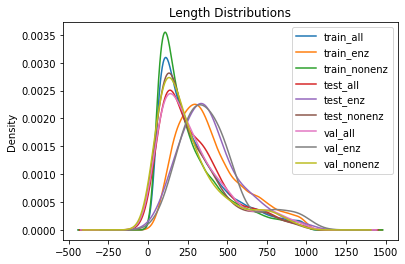

In [45]:
for data_set in data_sets:
    df = data_frames[data_set]['length']
    df.plot.kde(title="Length Distributions", label=data_set+"_all", legend=True)
    df_enz = enzyms[data_set]['length']
    df_enz.plot.kde(title="Length Distributions", label=data_set+"_enz", legend=True)
    df_nonenz = non_enzyms[data_set]['length']
    df_nonenz.plot.kde(title="Length Distributions", label=data_set+"_nonenz", legend=True)

# Predictions

create a folder named `databases` and run these commands under that folder to create the matching results `databases/resultDB.m8`

* `mmseqs createdb ../data/ec_vs_NOec_pide20_c50_test.fasta testDB`
* `mmseqs createdb ../data/ec_vs_NOec_pide20_c50_train.fasta trainDB`
* `mmseqs search testDB trainDB resultDB tmp --num-iterations 5 -s 7.0`
* `mmseqs convertalis testDB trainDB resultDB resultDB.m8 --format-output "query,target,evalue,raw"`


In [37]:
results =  pd.read_csv("databases/resultDB.m8",sep="\\t",names=['query','target','e-val','score'], engine="python")
results

,query,target,e-val,score
0,P55526,Q12204,2.947000e-04,98
1,Q2EET0,P04889,3.857000e-05,85
2,Q8HUH1,Q8F140,7.385000e-14,166
3,P21078,Q80HT6,2.041000e-05,98
4,Q9HDY1,P50275,1.810000e-19,227
...,...,...,...,...
812,Q86HT3,Q12238,3.612000e-04,80
813,Q86HT3,P73055,1.454000e-05,90
814,Q86HT3,Q9LF68,4.274000e-07,100
815,B0D1L7,O00258,1.437000e-09,133


In [65]:
len(results["query"].unique())


151

In [140]:
def get_binary_class(protein): # True if enzym
    return protein in annotations.index
def get_ec_top_level_class(protein):
    return int(annotations.loc[protein]['EC'][0]) if protein in annotations.index else 0

In [145]:
from functools import reduce
from operator import add

performance = {
    "binary": {
        "accuracy": 0.0,
        "recall": 0.0,
        "precision": 0.0,
        "TP": 0,
        "FP": 0,
        "TN": 0,
        "FN": 0,
        "unmatched": {
            "enzyme": 0,
            "non-enzyme": 0,
        }
    },
    "multiclass": {
        "accuracy" : 0.0,
        "classes" : {
            0: {
                "predicted": 0,
                "not_predicted": 0,
                "unmatched": 0
            },
            1: {
                "predicted": 0,
                "not_predicted": 0,
                "unmatched": 0
            },
            2: {
                "predicted": 0,
                "not_predicted": 0,
                "unmatched": 0
            },
            3: {
                "predicted": 0,
                "not_predicted": 0,
                "unmatched": 0
            },
            4: {
                "predicted": 0,
                "not_predicted": 0,
                "unmatched": 0
            },
            5: {
                "predicted": 0,
                "not_predicted": 0,
                "unmatched": 0
            },
            6: {
                "predicted": 0,
                "not_predicted": 0,
                "unmatched": 0
            },
            7: {
                "predicted": 0,
                "not_predicted": 0,
                "unmatched": 0
            }
        }
    }
}
for prot in data_frames["test"].index:
    binary_label = get_binary_class(prot)
    top_level_class = get_ec_top_level_class(prot)
        
    if prot in results['query'].unique():
        match = results.loc[results["query"] == prot].sort_values(by=['score'], ascending=False).iloc[0]["target"]
        
        bin_prediction = get_binary_class(match)
        if binary_label:
            if bin_prediction:
                performance["binary"]["TP"] += 1
            else:
                performance["binary"]["FN"] += 1
        else:
            if bin_prediction:
                performance["binary"]["FP"] += 1
            else:
                performance["binary"]["TN"] += 1
                
        top_level_class_pred = get_ec_top_level_class(match)
    
        if top_level_class == top_level_class_pred:
            performance["multiclass"]["classes"][top_level_class]["predicted"] += 1
        else:
            performance["multiclass"]["classes"][top_level_class]["not_predicted"] += 1
    else:
        if binary_label:
            performance["binary"]["unmatched"]["enzyme"] += 1
        else:
            performance["binary"]["unmatched"]["non-enzyme"] += 1
            
        performance["multiclass"]["classes"][top_level_class]["unmatched"] += 1
        
performance["binary"]["accuracy"] = (performance["binary"]["TP"] + performance["binary"]["TN"]) / len(data_frames["test"])
performance["binary"]["recall"] = performance["binary"]["TP"] / (performance["binary"]["TP"] + performance["binary"]["FN"] + performance["binary"]["unmatched"]["enzyme"])
performance["binary"]["precision"] = performance["binary"]["TP"] / (performance["binary"]["TP"] + performance["binary"]["FP"])

performance["multiclass"]["accuracy"] = reduce(add, list(map(lambda i: performance["multiclass"]["classes"][i]["predicted"], list(range(1,8))))) / len(data_frames["test"])

In [146]:
performance

{'binary': {'accuracy': 0.292,
  'recall': 0.45054945054945056,
  'precision': 0.9111111111111111,
  'TP': 41,
  'FP': 4,
  'TN': 105,
  'FN': 1,
  'unmatched': {'enzyme': 49, 'non-enzyme': 300}},
 'multiclass': {'accuracy': 0.072,
  'classes': {0: {'predicted': 105, 'not_predicted': 4, 'unmatched': 300},
   1: {'predicted': 7, 'not_predicted': 2, 'unmatched': 8},
   2: {'predicted': 17, 'not_predicted': 1, 'unmatched': 15},
   3: {'predicted': 12, 'not_predicted': 0, 'unmatched': 20},
   4: {'predicted': 0, 'not_predicted': 1, 'unmatched': 0},
   5: {'predicted': 0, 'not_predicted': 1, 'unmatched': 4},
   6: {'predicted': 0, 'not_predicted': 0, 'unmatched': 2},
   7: {'predicted': 0, 'not_predicted': 1, 'unmatched': 0}}}}